<a href="https://colab.research.google.com/github/davidlealo/sic_ai_2025_jun/blob/main/05deeplearning/clase_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumen Clase 42 – Modelos ARIMA

## 1. Repaso breve
- Las series de tiempo se componen de **tendencia, estacionalidad y ruido**.
- Es fundamental identificar si la serie es **estacionaria**.
- La diferenciación es clave para convertir una serie no estacionaria en estacionaria.

---

## 2. ARIMA: Autoregressive Integrated Moving Average
- **AR (p):** relación entre el valor actual y rezagos pasados.
- **I (d):** número de veces que la serie se diferencia para volverse estacionaria.
- **MA (q):** relación entre el valor actual y errores pasados.
- Notación general: **ARIMA(p,d,q)**.

---

## 3. Extensiones del modelo
- **SARIMA (Seasonal ARIMA):** incorpora la estacionalidad explícitamente.
  - Notación: ARIMA(p,d,q)(P,D,Q)[m].
  - Ejemplo: (1,1,1)(1,0,0)[12] → modelo con un rezago estacional de 12 meses.
- **ARIMAX:** incluye variables externas (exógenas) como predictores.

---

## 4. Procedimiento de modelado
1. **Visualización inicial** → detectar patrones y estacionalidad.
2. **Pruebas de estacionariedad** (ADF test).
3. **Transformaciones y diferenciación** → aplicar logaritmos o restas.
4. **Identificación de parámetros p, d, q** con gráficos de:
   - **ACF (Función de Autocorrelación).**
   - **PACF (Función de Autocorrelación Parcial).**
5. **Estimación del modelo** con software estadístico.
6. **Evaluación de residuos** → deben ser ruido blanco.
7. **Pronóstico** → obtener valores futuros.

---

## 5. Ejemplo aplicado
- Dataset trabajado: `AirPassengers`.
- Pasos:
  - Se diferenció la serie para lograr estacionariedad.
  - Se estimó un modelo ARIMA.
  - Se validaron residuos.
  - Se generaron pronósticos con intervalos de confianza.

---

## 6. Conclusiones
- ARIMA es un modelo **flexible** y ampliamente usado en predicciones.
- SARIMA amplía el modelo para capturar **estacionalidad**.
- ARIMAX permite incluir factores externos para mayor precisión.
- La clave está en:
  - Diagnóstico correcto.
  - Selección adecuada de parámetros.
  - Validación de residuos.


In [1]:
install.packages("forecast")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



[[1]]
[1] "forecast"  "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "tseries"   "forecast"  "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "ggplot2"   "tseries"   "forecast"  "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[1] 12

[1] 1949    1

[1] 1960   12

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  104.0   180.0   265.5   280.3   360.5   622.0 

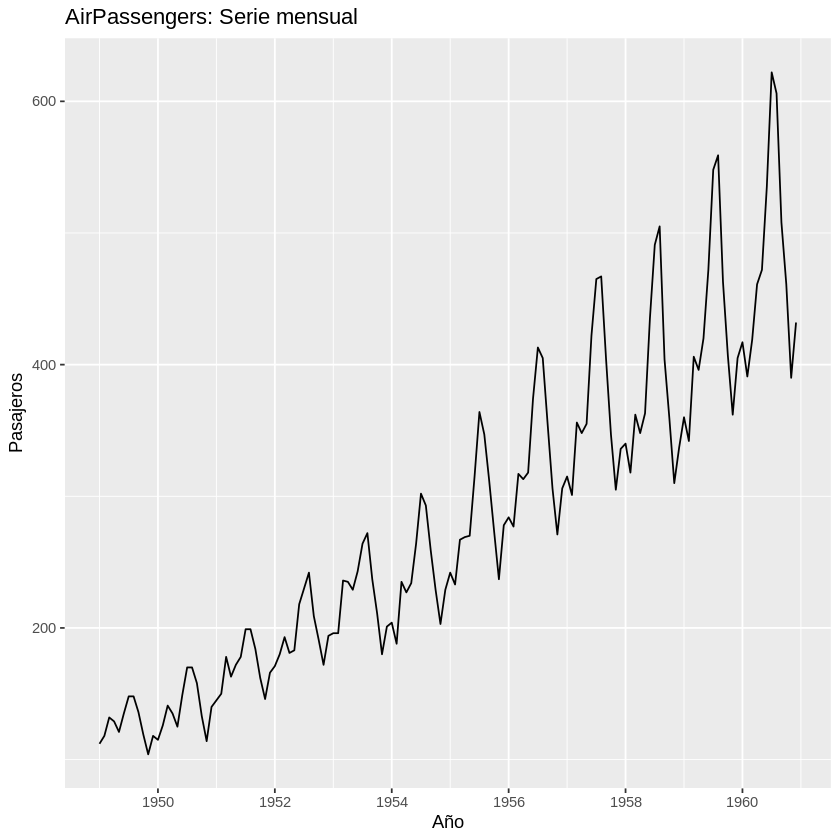

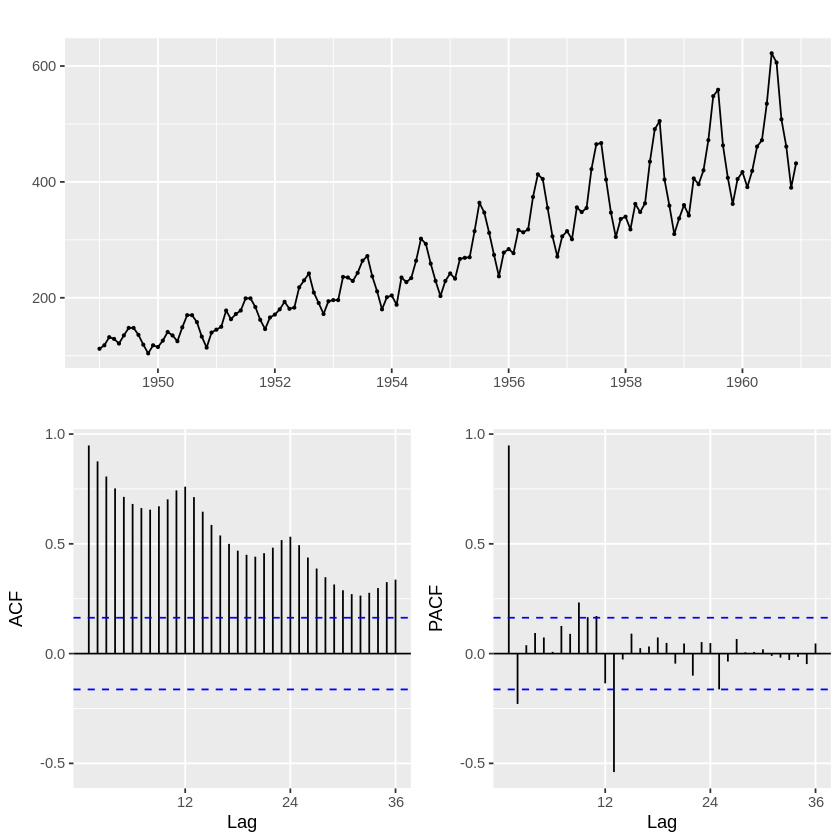

In [2]:
# =========================
# Clase 42 – Series de Tiempo en R
# ARIMA / SARIMA con diagnóstico y pronóstico
# =========================

# 0) Paquetes
pkgs <- c("forecast", "tseries", "ggplot2")
to_install <- pkgs[!pkgs %in% installed.packages()[, "Package"]]
if (length(to_install)) install.packages(to_install, dependencies = TRUE)
lapply(pkgs, library, character.only = TRUE)

# 1) Datos de ejemplo
data("AirPassengers")            # Serie mensual 1949–1960
ts_data <- AirPassengers         # Objeto ts: frecuencia = 12 (mensual)
frequency(ts_data)               # Chequear frecuencia (debería ser 12)
start(ts_data); end(ts_data)     # Inicio/fin

# 2) Inspección rápida
autoplot(ts_data) +
  ggplot2::labs(title = "AirPassengers: Serie mensual",
                x = "Año", y = "Pasajeros")

summary(ts_data)                 # Mínimo, máximo, cuartiles, media
ggtsdisplay(ts_data)             # Serie + ACF/PACF

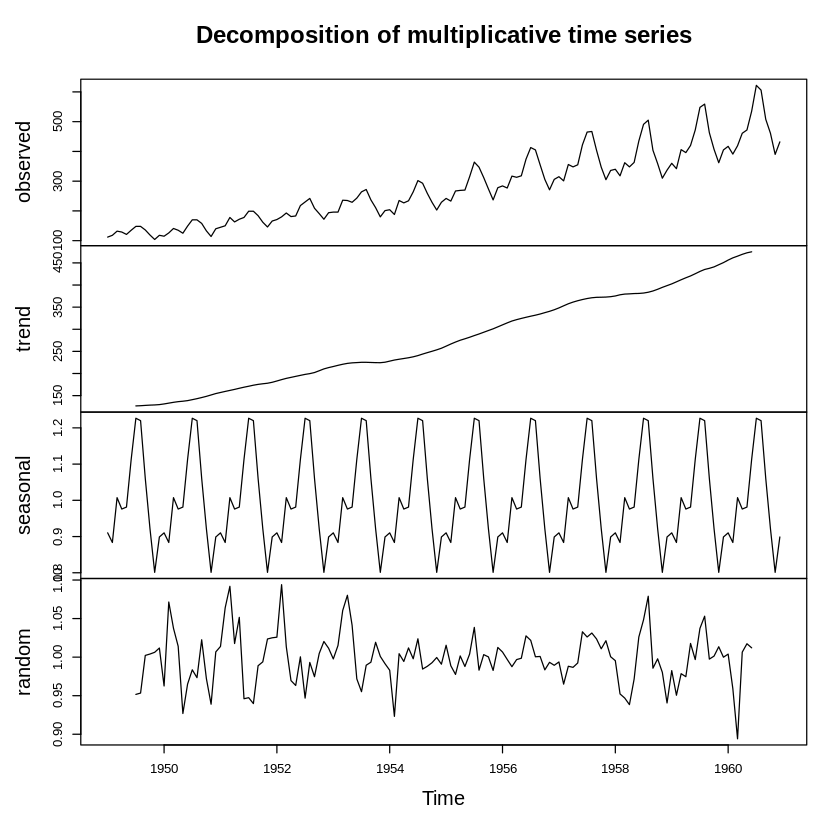

In [3]:
# 3) Descomposición
decomp <- decompose(ts_data, type = "multiplicative")
plot(decomp)

Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”


[1] 0.01

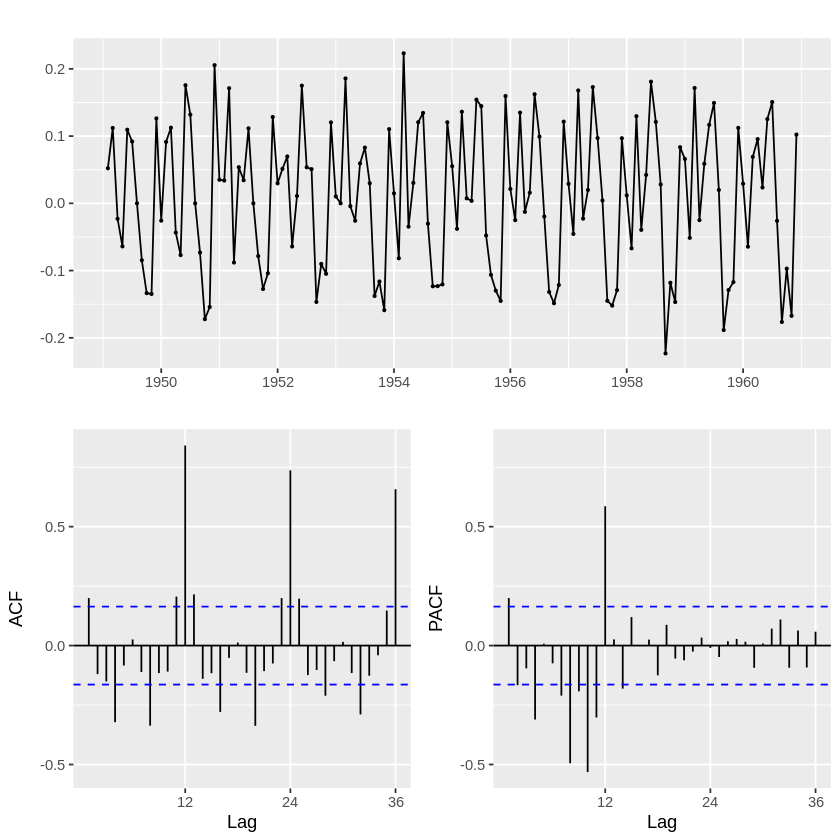

In [4]:
# 4) Prueba de estacionariedad (ADF)
# (ARIMA requiere estacionariedad; si p-value alto, diferenciar)
adf <- adf.test(ts_data)
adf$p.value

# Diferenciación si fuese necesario (aquí la usaremos para ilustrar)
ts_diff <- diff(log(ts_data))    # Log + diferencia: estabiliza varianza y tendencia
ggtsdisplay(ts_diff)

Series: log(ts_data) 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 = 0.001371:  log likelihood = 244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[12]
Q* = 26.446, df = 22, p-value = 0.233

Model df: 2.   Total lags used: 24



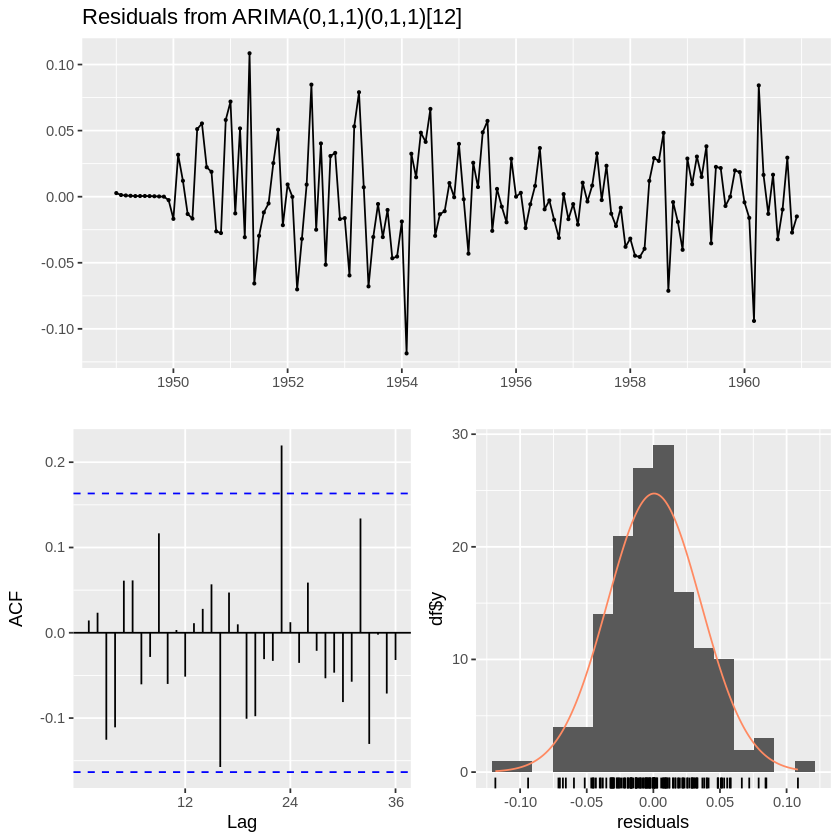

In [5]:
# 5) ARIMA automático (sobre log de la serie)
fit_arima <- auto.arima(log(ts_data))  # auto.p, auto.d, auto.q y estacionalidad si corresponde
summary(fit_arima)

# Diagnóstico de residuos (deben lucir como ruido blanco)
checkresiduals(fit_arima)        # Incluye test de Ljung-Box y ACF de residuos

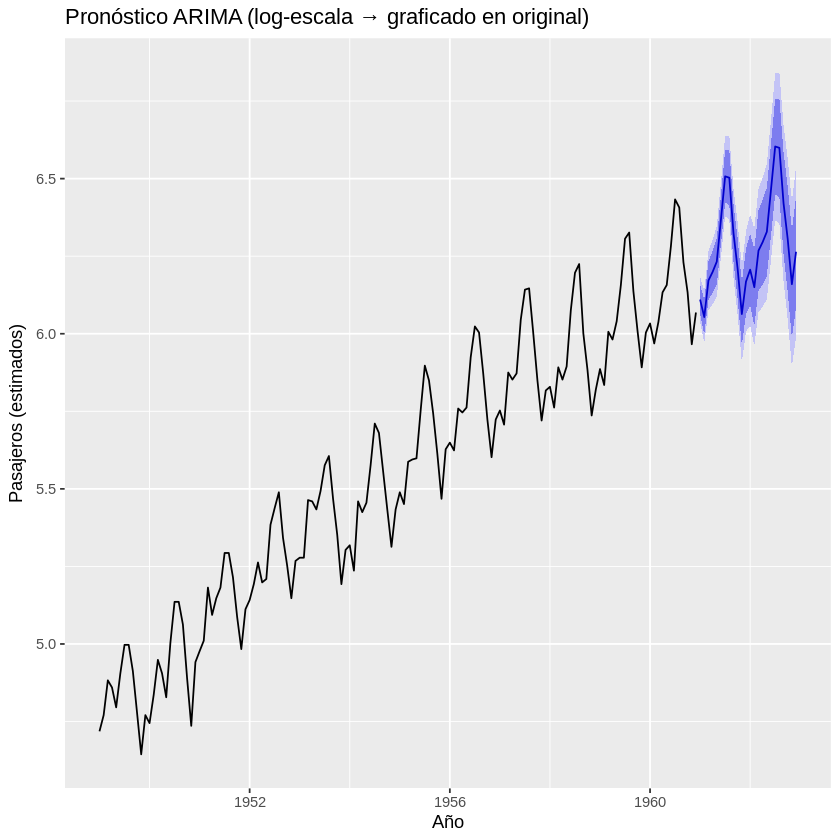

In [6]:
# 6) Pronóstico con ARIMA
h <- 24                          # 24 meses (2 años)
fc_arima <- forecast(fit_arima, h = h)
autoplot(fc_arima) +
  ggplot2::labs(title = "Pronóstico ARIMA (log-escala → graficado en original)",
                x = "Año", y = "Pasajeros (estimados)")

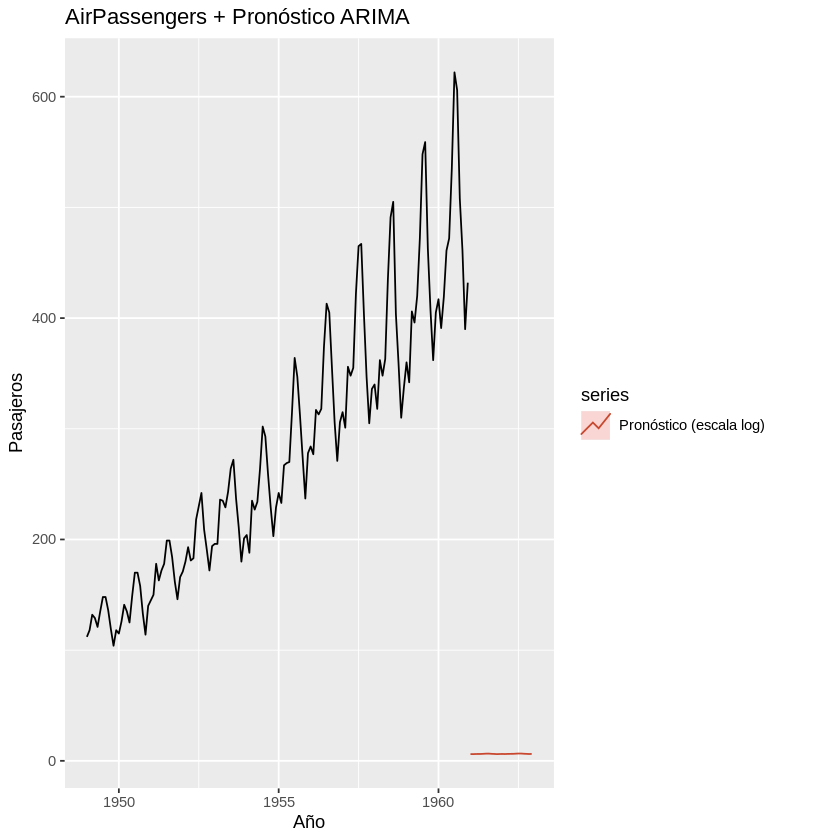

In [7]:
# Para mostrar en escala original:
fc_arima_orig <- ts(exp(fc_arima$mean), start = end(ts_data) + c(0, 1), frequency = 12)
autoplot(ts_data) +
  autolayer(fc_arima, series = "Pronóstico (escala log)") +
  ggplot2::labs(title = "AirPassengers + Pronóstico ARIMA", x = "Año", y = "Pasajeros")

Series: log(ts_data) 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 = 0.001371:  log likelihood = 244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[12]
Q* = 26.446, df = 22, p-value = 0.233

Model df: 2.   Total lags used: 24



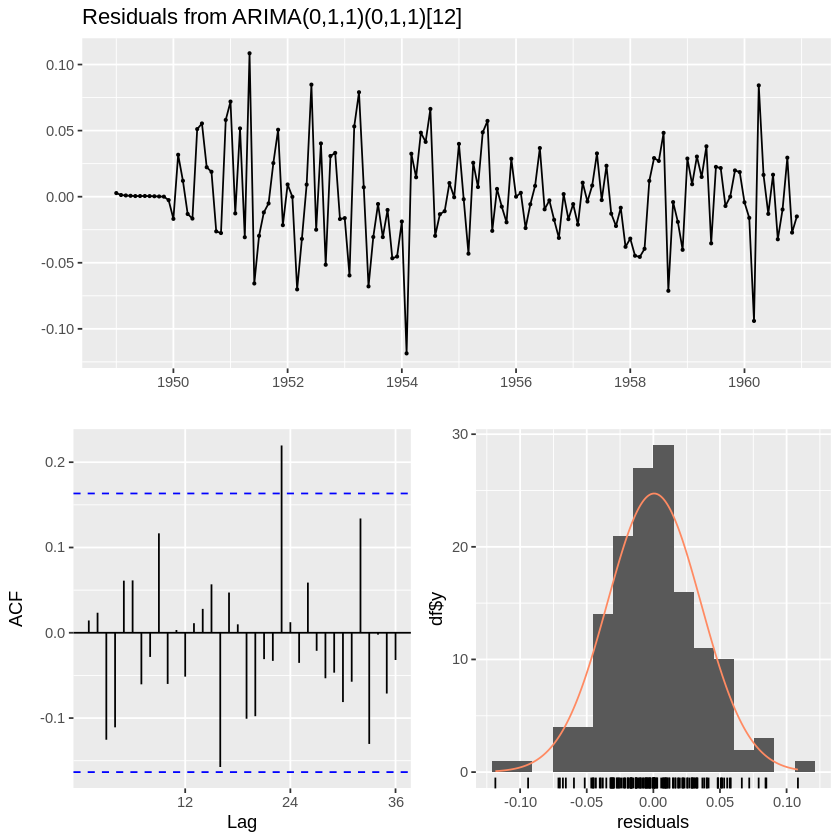

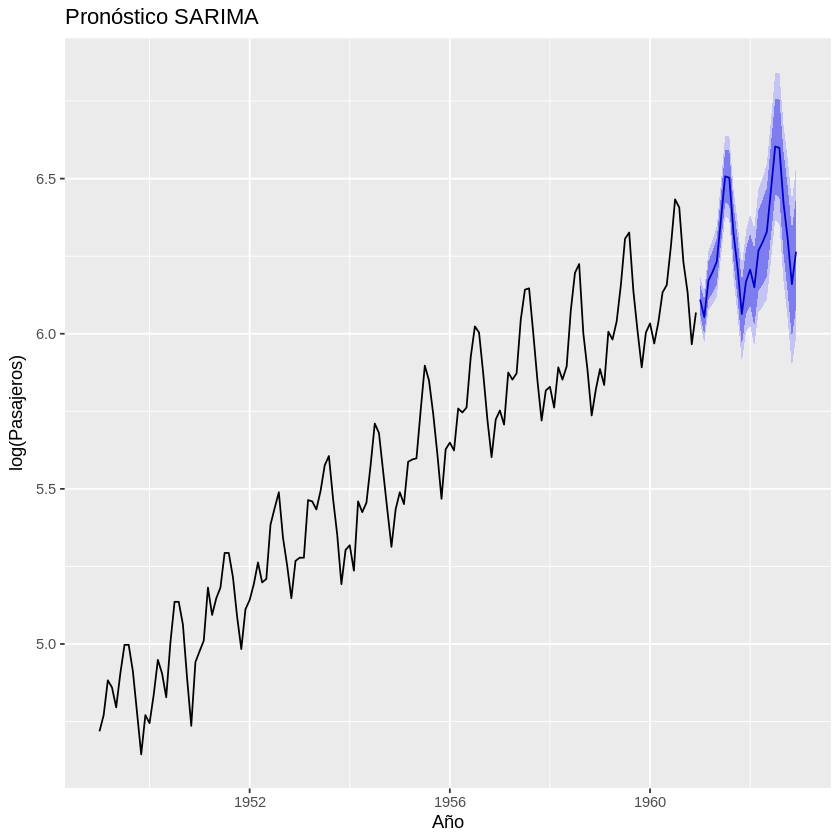

In [8]:
# 7) SARIMA manual (ejemplo)
#    Supón que identificaste (p,d,q) = (0,1,1) y (P,D,Q)[m] = (0,1,1)[12] sobre log
fit_sarima <- Arima(log(ts_data),
                    order = c(0,1,1),
                    seasonal = list(order = c(0,1,1), period = 12))
summary(fit_sarima)
checkresiduals(fit_sarima)

fc_sarima <- forecast(fit_sarima, h = h)
autoplot(fc_sarima) +
  ggplot2::labs(title = "Pronóstico SARIMA", x = "Año", y = "log(Pasajeros)")


--- Métricas hold-out (1959–1960) ---
MAE : 39.45
RMSE: 43.18
MAPE: 8.52%


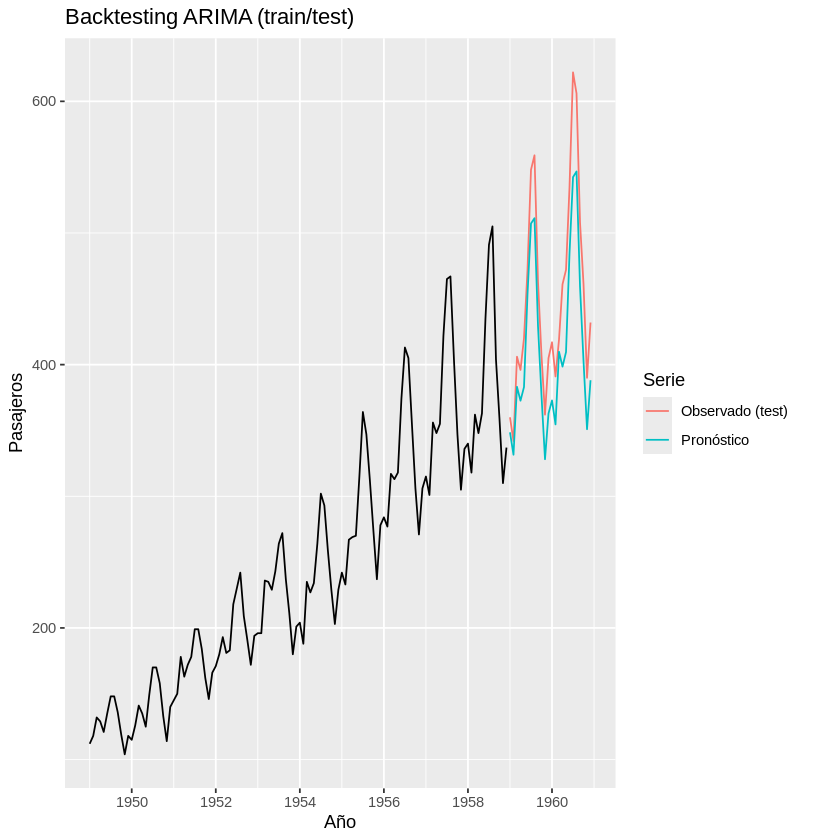

In [9]:
# 8) Evaluación con hold-out (backtesting simple)
#    Usamos los últimos 24 meses como test
n_test <- 24
ts_train <- window(log(ts_data), end = c(1958, 12))   # hasta 1958
ts_test  <- window(log(ts_data), start = c(1959, 1))  # 1959-1960

fit_cv <- auto.arima(ts_train)
fc_cv  <- forecast(fit_cv, h = n_test)

# Métricas en escala original (exp())
obs <- exp(ts_test)
pred <- exp(fc_cv$mean)

MAE  <- mean(abs(obs - pred))
RMSE <- sqrt(mean((obs - pred)^2))
MAPE <- mean(abs((obs - pred)/obs))*100

cat("\n--- Métricas hold-out (1959–1960) ---\n")
cat(sprintf("MAE : %.2f\nRMSE: %.2f\nMAPE: %.2f%%\n", MAE, RMSE, MAPE))

autoplot(exp(ts_train)) +
  autolayer(obs, series = "Observado (test)") +
  autolayer(pred, series = "Pronóstico") +
  ggplot2::labs(title = "Backtesting ARIMA (train/test)",
                x = "Año", y = "Pasajeros") +
  ggplot2::scale_color_discrete(name = "Serie")

# 9) Notas:
# - Usa log() cuando la varianza crece con el nivel de la serie.
# - Si checkresiduals() muestra autocorrelación en residuos o p-value Ljung-Box bajo,
#   ajusta órdenes (p,d,q)(P,D,Q)[m] o considera más diferenciación.
# - Para incluir regresores externos (ARIMAX), usa Arima(y, xreg = ...)
